<a href="https://colab.research.google.com/github/vhppacheco/ic-ita-finance-ia/blob/main/clustering/Clustering_modeling_v13_vTranslate_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Installing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install umap-learn
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 54.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f9503ea7ba8ffb8fd00219999cfccddeca32493586ddc3abeed858a6241a18b7
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1da2343adb31d48b1ce2753725fc0e9a7a9133dcbd72d67432dc1f39febbab3e
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 28.2 MB/s 


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12
from math import sqrt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pylab as plt
import sklearn as sklearn
from sklearn_extra.cluster import KMedoids
import random
import scipy.cluster.hierarchy as sc
from sklearn.cluster import AgglomerativeClustering

# Reading data (S&P500 & Ibov)



##Reading data

In [5]:
#Read dataset from IBOVESPA 
df_ibov = pd.read_excel('/content/drive/MyDrive/IC ITA/df_Ibov_Final_vTranslate.xlsx')
df_ibov['Indice'] = 'Ibov'
#Rename column to create a single Beta column in the main dataframe
df_ibov = df_ibov.rename(columns={'B Ibovespa':'B'})

#Read dataset from S&P500 
df_sp500 = pd.read_excel('/content/drive/MyDrive/IC ITA/df_SP500_Final_vTranslate.xlsx')
df_sp500['Indice'] = 'S&P500'
#Rename column to create a single Beta column in the main dataframe
df_sp500 = df_sp500.rename(columns={'B S&P500':'B'})

df_indicators = pd.concat([df_sp500,df_ibov])

##EDA

In [6]:
df_indicators.isna().sum()

Quarter         0
CR              0
QR              0
DTEQ            0
DTEB            0
NPM             0
ROA             0
ROE             0
PTE             0
PTB             0
EV              0
EVTE            0
PFCF            0
R               0
B               0
IRR             0
BB              0
V               0
SR              0
VaR             0
MDD             0
Date Release    0
Ticker          0
Setor NAICS     0
Indice          0
dtype: int64

In [7]:
#Create the adjusted ticker for brazilian stocks, with the ".SA" in the end of oeach stock ticker
df_indicators['Adj. Ticker']=df_indicators['Ticker'] 
df_indicators.loc[df_indicators['Indice']=='Ibov','Adj. Ticker'] = df_indicators.loc[df_indicators['Indice']=='Ibov','Adj. Ticker']+str('.SA')

In [8]:
#Top 10 stocks with highest Sharpe Ratio
df_indicators.sort_values(by='SR',ascending=False)

,Quarter,CR,QR,DTEQ,DTEB,NPM,ROA,ROE,PTE,PTB,...,BB,V,SR,VaR,MDD,Date Release,Ticker,Setor NAICS,Indice,Adj. Ticker
881,2Q2020,0.969591,0.969591,-2143.867924,4408.500000,-63.422819,-2.907916,-72.721165,-13.235294,-3.116362,...,11.563151,59.391471,157.899168,12.679423,-20.795107,2020-06-30,APA,"Mineração, exploração de pedreiras e extração ...",S&P500,APA
1335,4Q2019,1.248375,0.828998,263.700149,17.963424,0.955696,0.273260,0.993845,221.365037,1.674545,...,5.294484,40.617418,131.332159,8.806178,-14.818182,2019-12-31,POSI3,Indústria manufatureira,Ibov,POSI3.SA
1697,2Q2020,1.171241,0.793256,474.113686,15.680451,1.231061,0.224238,1.287384,319.899453,4.840789,...,10.289778,47.397036,126.037491,10.079435,-14.585415,2020-06-30,VIIA3,Comércio varejista,Ibov,VIIA3.SA
2753,2Q2020,3.224224,3.187735,280.367522,-131.806724,-79.066972,-1.626362,-6.186152,-32.048000,1.928516,...,27.494833,69.298549,117.537770,14.893212,-19.277108,2020-06-30,CZR,Hotel e restaurante,S&P500,CZR
253,2Q2019,0.826152,1.627830,614.760245,8.758159,5.786735,0.389633,2.784939,86.624658,2.412444,...,4.105840,42.520387,87.108130,9.283152,-17.391304,2019-06-30,BPAN4,Serviços financeiros e seguros,Ibov,BPAN4.SA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9173,2Q2017,1.572633,1.251941,87.379856,17.381348,-1.085500,-0.108199,-0.202743,-1316.800000,2.306606,...,62.445585,8.187481,-2.971498,1.685957,-0.368863,2017-06-30,SLB,"Mineração, exploração de pedreiras e extração ...",S&P500,SLB
7590,3Q2017,1.455595,0.856227,165.371966,23.946995,6.372682,0.691690,1.835552,88.895833,1.642211,...,40.811370,9.612334,-2.989691,1.964095,-1.340782,2017-09-30,NWL,Indústria manufatureira,S&P500,NWL
52,1Q2017,1.450062,0.243984,178.755389,2.739156,5.522670,1.476736,4.532727,88.618520,2.847379,...,154.075475,7.803276,-2.996925,1.613231,0.000000,2017-04-22,AAP,Comércio varejista,S&P500,AAP
8383,4Q2017,0.570221,0.490679,285.456742,19.941721,4.049844,0.188047,0.724840,281.363636,1.980111,...,28.948368,8.142755,-3.409925,1.666693,-1.113468,2017-12-31,PPL,"Empresa de eletricidade, gás e água",S&P500,PPL


In [9]:
#general information about the dataframe
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12936 entries, 0 to 1775
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Quarter       12936 non-null  object        
 1   CR            12936 non-null  float64       
 2   QR            12936 non-null  float64       
 3   DTEQ          12936 non-null  float64       
 4   DTEB          12936 non-null  float64       
 5   NPM           12936 non-null  float64       
 6   ROA           12936 non-null  float64       
 7   ROE           12936 non-null  float64       
 8   PTE           12936 non-null  float64       
 9   PTB           12936 non-null  float64       
 10  EV            12936 non-null  float64       
 11  EVTE          12936 non-null  float64       
 12  PFCF          12936 non-null  float64       
 13  R             12936 non-null  float64       
 14  B             12936 non-null  float64       
 15  IRR           12936 non-null  float64

Normalization:

Normalization of each *x* indicator is given by:

\begin{equation}
\ x_i' = \frac{x_i - min(x)}{max(x) - min(x)}\
\end{equation}

In [10]:
#Normalization
columns = ['CR', 'QR',
       'DTEQ', 'DTEB',
       'NPM', 'ROA',
       'ROE', 'PTE',
       'PTB', 'EV',
       'EVTE',
       'PFCF',
       'R',
       'IRR',
       'BB',
       'V',
       'VaR',
       'MDD',
       'SR', 'B']

for column in columns:
  df_indicators[column] = (df_indicators[column]-min(df_indicators[column].dropna())) /(max(df_indicators[column].dropna())-min(df_indicators[column].dropna()))

# Analysis

-------------------------------------------------------------------------------
##Selection of assets with highest Obj. in each cluster each semester
------------------------------------------------------------------------------

---
Equation of selection of optimum cluster:

\begin{equation}
\ Obj \ = max(\frac{Current Ratio + Quick ratio + Net Profit Margin + Return on Assets + Return on Equity + Internal Rate of Return + Sharpe Ratio + L}{Debt−to−EBITDA + Enterprise Value−to−EBITDA + Debt−to−Equity + Price−to−Earning + Price−to−Book + Price−to−Free Cash Flow + Volatility + Value at Risk + Maximum Drawdown + Beta})\
\end{equation}

In [11]:
def compare_quarter(quarter_0,n_assets):

  
  #Generating the objective function
  df_indicators['max'] = df_indicators['CR']+df_indicators['QR']+df_indicators['NPM']+df_indicators['ROA']+df_indicators['ROE']+df_indicators['IRR']+df_indicators['SR']
  df_indicators['min'] = df_indicators['DTEB']+df_indicators['PTE']+df_indicators['EVTE']+df_indicators['PFCF']+df_indicators['V']+df_indicators['VaR']+df_indicators['MDD']+df_indicators['DTEQ']+df_indicators['PTB']+df_indicators['B']
  df_indicators['Cluster_select'] = df_indicators['max']/df_indicators['min']
  df_indicators['Cluster_select'] = (df_indicators['Cluster_select']-min(df_indicators['Cluster_select'].dropna()))/(max(df_indicators['Cluster_select'].dropna())-min(df_indicators['Cluster_select'].dropna()))

  #UMAP application
  indicators_application = df_indicators.loc[df_indicators['Quarter'].astype(str) == quarter_0]
  indicators_application = indicators_application
  indicators_application = indicators_application.fillna(0)

  columns = ['CR', 'QR',
       'DTEQ', 'DTEB',
       'NPM', 'ROA',
       'ROE', 'PTE',
       'PTB', 'EV',
       'EVTE',
       'PFCF',
       'R',
       'IRR',
       'BB',
       'V',
       'VaR',
       'MDD',
       'SR', 'B']

  indicators_data = indicators_application[columns].values
  scaled_indicators_data = StandardScaler().fit_transform(indicators_data)

  reducer = umap.UMAP()
  embedding = reducer.fit_transform(indicators_data)

  #K-Means data preparation (to be used in the Silhouette and Davies-Bouldin tests)
  kmeans_input = pd.DataFrame(embedding)
  kmeans_input.rename(columns={0:'x',1:'y'},inplace=True)

  columns = ['x','y']

  #Normalization
  for column in columns:
    kmeans_input[column] = (kmeans_input[column]-min(kmeans_input[column].dropna()))/(max(kmeans_input[column].dropna())-min(kmeans_input[column].dropna()))

  X = kmeans_input.iloc[:,[0,1]].values

  cluster_num_tests = []
  for i in range(2,20):
    cluster_num_tests.append(i)
  
  #Silhouette and Davies-Bouldin tests
  silhouette_results = []
  davies_bouldin_results = []

  #Application of the Shilhouette and Davies-Bouldin indexes to select the number of clusters to be applied in the clustering models
  for cluster_num in (cluster_num_tests):

    kmeans = KMeans(n_clusters=cluster_num, random_state=0)
    kmeans_labels = kmeans.fit_predict(X)
    labels = kmeans_labels

    silhouette_results_i = [cluster_num,sklearn.metrics.silhouette_score(kmeans_input, labels, metric='euclidean')]
    silhouette_results.append(silhouette_results_i)

    davies_bouldin_i = [cluster_num, sklearn.metrics.davies_bouldin_score(kmeans_input, labels)]
    davies_bouldin_results.append(davies_bouldin_i)

  cluster_num_silhouette = pd.DataFrame(silhouette_results).rename(columns= {0:'cluster_num',1:'silhouette_score'}).sort_values(by='silhouette_score',ascending=False)['cluster_num'].iloc[0]
  cluster_num_davies_bouldin = pd.DataFrame(davies_bouldin_results).rename(columns= {0:'cluster_num',1:'davies_bouldin_score'}).sort_values(by='davies_bouldin_score',ascending=True)['cluster_num'].iloc[0]
  cluster_num = int((cluster_num_silhouette+cluster_num_davies_bouldin)/2)

  #K-Means Application
  kmeans = KMeans(n_clusters=cluster_num, random_state=0)
  kmeans_labels = kmeans.fit_predict(X)
  
  kmeans_output = pd.DataFrame(np.column_stack((kmeans_input, kmeans_labels)))
  kmeans_output = kmeans_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Filling out the cluster column
  if 'Cluster UMAP K-Means' in (indicators_application.columns):
    indicators_application.drop('Cluster UMAP K-Means',axis='columns',inplace=True)

  for i in range(0,len(indicators_application)):
    cluster = int(kmeans_output['Cluster'].iloc[i])
  indicators_application.insert(0,'Cluster UMAP K-Means', kmeans_labels,allow_duplicates=True)


  #PAM Application
  X = kmeans_input.iloc[:,[0,1]].values
  kmedoids = KMedoids(n_clusters=cluster_num, random_state=0).fit(X)
  kmedoids.predict([X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))],
                  X[random.randint(0, len(X))]])

  #Filling out the cluster column
  if 'Cluster PAM' in (indicators_application.columns):
    indicators_application.drop('Cluster PAM',axis='columns',inplace=True)


  for i in range(0,len(indicators_application)):
    cluster = int(kmedoids.labels_[i])
  indicators_application.insert(0,'Cluster PAM', kmedoids.labels_,allow_duplicates=True)

  #Hierarchical
  Y = kmeans_input
  cluster_hierarquical = AgglomerativeClustering(n_clusters=cluster_num, affinity='euclidean', linkage='ward')
  hierarquical = cluster_hierarquical.fit(Y)

  hierarquical_output = pd.DataFrame(np.column_stack((Y, hierarquical.labels_)))
  hierarquical_output = hierarquical_output.rename(columns={0:'x',1:'y',2:'Cluster'})

  #Filling out the cluster column
  if 'Cluster Hierarquical' in (indicators_application.columns):
    indicators_application.drop('Cluster Hierarquical',axis='columns',inplace=True)


  for i in range(0,len(indicators_application)):
    cluster = int(hierarquical_output['Cluster'].iloc[i])
  indicators_application.insert(0,'Cluster Hierarquical', hierarquical.labels_,allow_duplicates=True)

  df_indicators_dtref = indicators_application


  #Select n stocks with the highest Sharpe Ratio of each cluster
  assets_select = df_indicators_dtref.head(0)
  for model in ('Cluster UMAP K-Means','Cluster PAM',	'Cluster Hierarquical'):
    for i in range(0,cluster_num):
      assets_select_i = df_indicators_dtref.loc[df_indicators_dtref[model].astype(int)==int(i)].sort_values(by='Cluster_select',ascending=False)[:n_assets]
      assets_select_i['Modelo'] = str(model)
      if len(assets_select)==0:
        assets_select = assets_select_i.copy()
      else:
        assets_select = pd.concat([assets_select,assets_select_i])

  assets_select = assets_select[['Ticker','Setor NAICS','SR','Cluster_select']].drop_duplicates()
  assets_select = assets_select.reset_index()[['Ticker','Setor NAICS','SR','Cluster_select']]
  assets_select = assets_select.loc[:,~assets_select.columns.duplicated()]
  return assets_select,cluster_num,cluster_num_silhouette,cluster_num_davies_bouldin

## Basket for 2 assets with highest Obj.

In [12]:
quarters = ['1Q2016','2Q2016','3Q2016','4Q2016','1Q2017','2Q2017','3Q2017','4Q2017','1Q2018','2Q2018','3Q2018','4Q2018','1Q2019','2Q2019','3Q2019','4Q2019','1Q2020','2Q2020','3Q2020','4Q2020','1Q2021','2Q2021','4Q2021']

#Final Dataframe
df_final = pd.DataFrame()


#Create an empty dataframe
final_basket = pd.DataFrame(columns=['Ticker','Setor NAICS','SR','Cluster_select','Quarter'])

cluster_num_time = []

#loop to run through each quarter
for quarter in quarters:


    #Get the stock basket for the current iteration quarter
    basket = compare_quarter(quarter,2)

    cluster_num_time_i = [quarter,basket[1],basket[2],basket[3]]
    cluster_num_time.append(cluster_num_time_i)
    
    basket = basket[0]

    #Create a temporary basket
    basket_temp = pd.DataFrame(columns=['Ticker','Setor NAICS','SR','Cluster_select'])

    #Filter current iteration quarter
    df_indicators_dtref = df_indicators.loc[df_indicators['Quarter'].astype(str) == quarter]

    final_basket =  basket[['Ticker','SR']].merge(df_indicators_dtref[['Ticker','SR','Setor NAICS','Cluster_select']], how='inner', on = 'Ticker').rename(columns={'Sharpe Ratio_y':'SR','Setor NAICS_x':'Setor NAICS'})
    
    #Analyse the objective function result in the final basket dataframe
    obj_final_basket = final_basket['Cluster_select'].mean()
    if np.isnan(obj_final_basket) :
        obj_final_basket = 0

    #Get each sotck of final basket
    for i in range(len(basket)):

        #Get the Ticker from basket
        ticker = basket['Ticker'].loc[i]

        #Verify if the ticker is in the final basket
        if ticker in final_basket:

            #If yes, add the ticker in the temporary basket
            basket_temp = basket_temp.append(basket.iloc[i,:])

        else:
            #If not, compare the Obj's
            
            #Get the Ticker Obj. from the quarterly basket
            obj = basket['Cluster_select'].loc[i]

            #If the Ticker Obj is higher than the average Obj of final basket
            if obj >= obj_final_basket:

                #Add in the temporary basket
                basket_temp = basket_temp.append(basket.iloc[i,:])

    #Replace the final basket by temporary basket
    basket_temp['Quarter'] = quarter

    
    final_basket['Quarter'] = quarter
    if len(basket_temp)>0:
      final_basket = basket_temp
    

    df_final = df_final.append(final_basket)

    #Determine the average Obj of the final basket
    obj_final_basket = final_basket['Cluster_select'].mean()
    if np.isnan(obj_final_basket) :
        obj_final_basket = 0

####Output

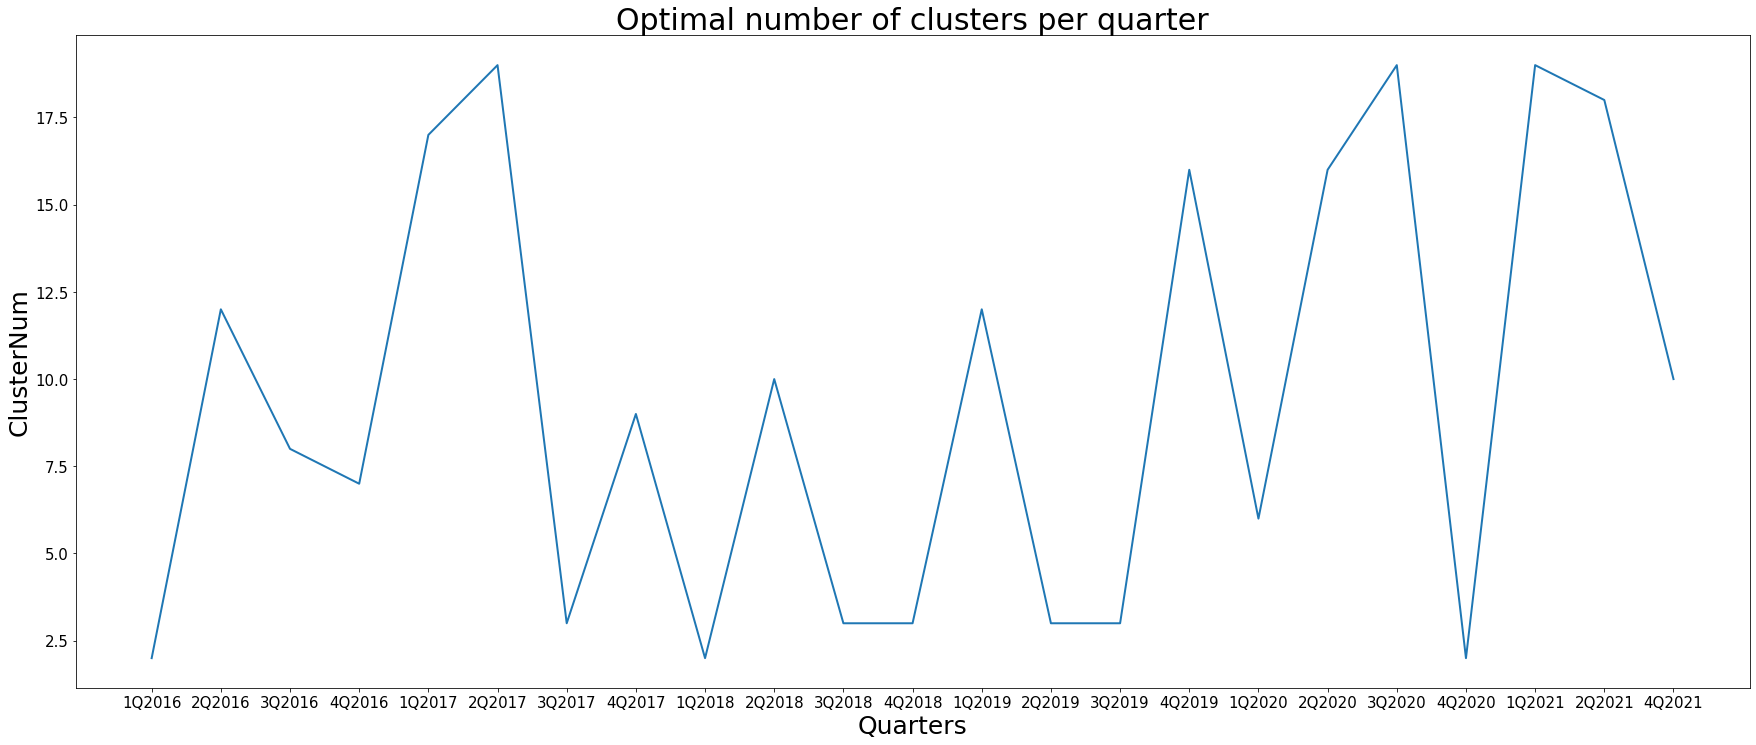

In [13]:
cluster_num_historico = pd.DataFrame(cluster_num_time).rename({0:'Quarter',1:'ClusterNum',2:'Silhouette',3:'Davies-Bouldin'},axis='columns')
rcParams['figure.figsize'] = 30,12
plt.plot(cluster_num_historico['Quarter'],cluster_num_historico['ClusterNum'],linewidth=2.0)
plt.xlabel("Quarters",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("ClusterNum",fontsize=25)
plt.title("Optimal number of clusters per quarter",fontsize=30)
plt.show()

In [14]:
df_final[df_final['Quarter']=='4Q2021']

,Ticker,Setor NAICS,SR,Cluster_select,Quarter
0,BRAP4,Administração de empresas e empreendimentos,0.037647,0.646276,4Q2021
1,NVDA,Indústria manufatureira,0.058054,0.475360,4Q2021
6,NLOK,Informação,0.027899,0.609187,4Q2021
7,VRSN,"Serviços profissionais, científicos e técnicos",0.063679,0.477551,4Q2021
8,VRTX,Indústria manufatureira,0.053044,0.481307,4Q2021
9,PFE,Indústria manufatureira,0.064543,0.474044,4Q2021
14,ANET,Indústria manufatureira,0.118209,0.477385,4Q2021
15,INCY,"Serviços profissionais, científicos e técnicos",0.031000,0.456208,4Q2021
22,NVR,Construção,0.058559,0.459002,4Q2021
23,MTD,Indústria manufatureira,0.069143,0.439901,4Q2021
